
# Exercise 2: Fraunhoffer and Fresnel

## Remarks

The fourier transform involves the transform factor $\exp{-\frac{ikx_j y}{D}}$. We can
compare this factor with that found in the lecture note, $\exp{-\frac{i2\pi j
n}{N}}$ to see that

\begin{align}
  2\pi \frac{n}{N} =& \frac{kAy}{D}\\
  f_n = \frac{n}{N\Delta} =& \frac{ky}{2\pi D}\\
  \therefore y_n = \frac{2\pi D}{k}f_n =& \lambda D f_n
\end{align}

For this exercise we adopt SI units throughout.


## Libraries

In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import scipy
import warnings
from scipy import integrate
from typing import Callable, SupportsComplex

# suppress scipy warning
warnings.filterwarnings(action = "ignore",
                        category = scipy.integrate.IntegrationWarning)


## Define constants

In [2]:
wavel = 500e-9  # wavelength
L = 5e-3    # total width of aperture

# parameters for the sinusoidal phase grating
s = 100e-6
m = 8


## Auxiliary functions.

Below are some helper functions that might turn out useful later on.

In [3]:
def fft(A: npt.ArrayLike, delta: float, wavel: float, D: float) -> tuple:
    """!
    @brief returns fft of provided data

    @param y aperture information.
    @param delta distance between aperture samples. 
    @param wavel wavelength of incident light.
    @param dist: distance D from screen to aperture.

    @return fourier-transformed Y and corresponding displacement on screen.
    """
    wfc = np.fft.fft(A) * delta
    wfc = np.fft.fftshift(wfc)

    fftsize = len(A)
    y = np.fft.fftfreq(fftsize, delta)
    y = np.fft.fftshift(y)
    y = wavel * D * y # transform to position coordinates

    return wfc, y

def get_A_list(aperture_func: Callable,
               fftsize: int,
               delta: float,
               **kwargs) -> npt.ArrayLike:
    """!
    @brief return discretised values of aperture

    @param aperture_func function describing aperture
    @param fftsize size of sample
    @param delta distance between samples

    @return list of aperture samples
    """
    # left limit, right limit
    llim = -fftsize / 2 * delta
    rlim = (fftsize / 2 - 1) * delta
    x = np.linspace(llim, rlim, fftsize)
    A = np.array([aperture_func(xx, **kwargs) for xx in x])
    return A


## Core Task 1: Fraunhoffer

For the top-hat, the analytic integral gives
\begin{equation}
  \psi(y) = 2 \frac{D}{ky} \sin{\frac{kyd}{2}} = \mathrm{sinc}(\frac{kyd}{2}) Dd
\end{equation}

Whereas the numerical FFT is given by
\begin{equation}
  \psi(y) = \Delta \Sigma^{N-1}_{j = 0} A(x_j) \exp{-\frac{ikx_j y}{D}}
\end{equation}

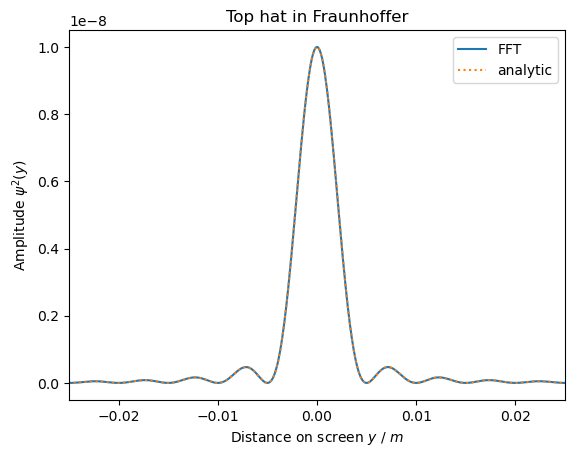

In [4]:
def top_hat(x: float, d: float) -> float:
    if np.abs(x) <= d / 2:
        return 1
    return 0

def top_hat_analytic_result(y: float, d: float, D: float, wavel: float) -> float:
    k = np.pi * 2 / wavel
    # numpy defines sinc as sin(pi x) / (pi x)
    return np.sinc(k * y * d / (2 * D) / np.pi) * D * d

def top_hat_test(wavel: float,
                 d: float,
                 D: float,
                 L: float,
                 fftsize: int):
    delta = L / fftsize
    A = get_A_list(top_hat, fftsize, delta, d = d) # evalutaed aperture
    wfc, y = fft(A, delta, wavel, D)
    intensity_fft = abs(wfc) ** 2

    intensity_analytic = top_hat_analytic_result(y, d, D, wavel) ** 2
 
    plt.plot(y, intensity_fft, label = 'FFT')
    plt.plot(y, intensity_analytic, linestyle = 'dotted', label = 'analytic')
    plt.xlim(-0.025, 0.025)
    plt.xlabel('Distance on screen $y$ / $m$')
    plt.ylabel('Amplitude $\psi^2(y)$')
    plt.legend()
    plt.title('Top hat in Fraunhoffer')
    plt.show()

top_hat_test(wavel = wavel, d = 100e-6, D = 1, L = L, fftsize = 2 ** 16)


Overall very good agreement.



## Core Task 2: The sinusoidal phase grating (Fraunhoffer)

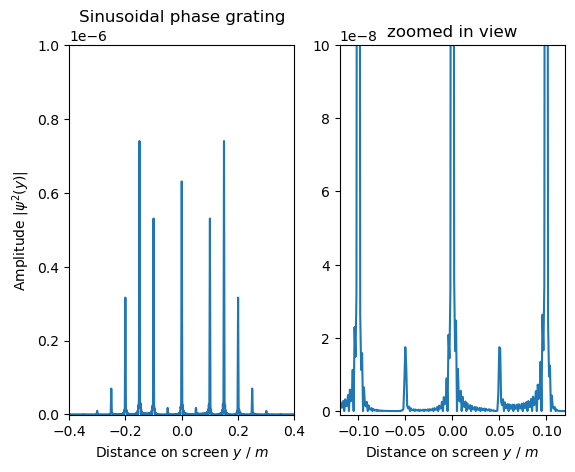

In [5]:
def sin_phase_grating(x: float, d: float, s: float, m: float) -> SupportsComplex:
    phi = (m / 2) * np.sin(2 * np.pi * x / s)
    A = 1 * np.exp(1j * phi) * top_hat(x, d = d)
    return A

def sin_phase_grating_test(wavel: float,
                           d: float,
                           s: float,
                           m: float,
                           D: float,
                           L: float,
                           fftsize: int):
    delta = L / fftsize
    A = get_A_list(sin_phase_grating, fftsize, delta, d = d, s = s, m = m)
    wfc, y = fft(A, delta, wavel, D)
    intensity_fft = abs(wfc) ** 2

    plt.subplot(1, 2, 1)
    plt.plot(y, intensity_fft, label = 'FFT')
    plt.xlim(-0.4, 0.4)
    plt.ylim(-0.01e-7, 1e-6)
    plt.xlabel('Distance on screen $y$ / $m$')
    plt.ylabel('Amplitude $|\\psi^2(y)|$')
    plt.title('Sinusoidal phase grating')

    plt.subplot(1, 2, 2)
    plt.plot(y, intensity_fft, label = 'FFT')
    plt.xlim(-0.12, 0.12)
    plt.ylim(-0.01e-7, 0.1e-6)
    plt.title('zoomed in view')
    plt.xlabel('Distance on screen $y$ / $m$')
    plt.show()

sin_phase_grating_test(wavel = wavel, d = 2e-3, s = s, m = m, D = 10,
                        L = L, fftsize = 2 ** 20)


Despite the pattern being largely symmetric, there appears to be a bias in one
direction. If we inverted the phase the bias seems to go the other way, so
perhaps it is expected.



## Core Task 3: Phase-corrected diffraction

We need to modify our aperture to the effective aperture:
\begin{equation}
  A(x) \rightarrow A'(x) = A(x) \exp{\frac{ikx^2}{2D}}
\end{equation}

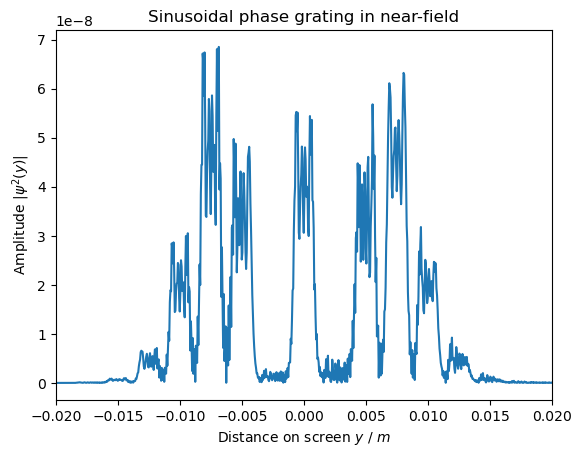

In [6]:
def phase_factor(x: float, wavel: float, D: float):
    k = np.pi * 2 / wavel
    return np.exp(1j * k * (x ** 2) / (2 * D))

def top_hat_corrected_test(wavel: float,
                           d: float,
                           D: float,
                           L: float,
                           fftsize: int):
    delta = L / fftsize
    
    def top_hat_corrected(x: float, d: float):
        return top_hat(x, d) * phase_factor(x, wavel, D)

    A = get_A_list(top_hat_corrected, fftsize, delta, d = d)
    wfc, y = fft(A, delta, wavel, D)
    intensity_fft = abs(wfc) ** 2
 
    plt.plot(y, intensity_fft, label = 'FFT')

    plt.xlabel('Distance on screen $y$ / $m$')
    plt.ylabel('Amplitude $\psi^2(y)$')
    plt.xlim(-0.5e-3, 0.5e-3)
    plt.title('Top hat aperture in near-field')
    plt.show()

# top_hat_corrected_test(wavel = wavel, d = 100e-6, D = 5e-3, L = L, fftsize = 2 ** 16)

def phase_grating_corrected_test(wavel: float,
                                 d: float,
                                 s: float,
                                 m: float,
                                 D: float,
                                 L: float,
                                 fftsize: int):
    delta = L / fftsize

    def phase_grating_corrected(x, d, s, m):
        return sin_phase_grating(x, d, s, m) * phase_factor(x, wavel, D)

    A = get_A_list(phase_grating_corrected, fftsize, delta, d = d, s = s, m = m)
    wfc, y = fft(A, delta, wavel, D)
    intensity_fft = abs(wfc) ** 2

    plt.plot(y, intensity_fft, label = 'FFT')
    plt.xlabel('Distance on screen $y$ / $m$')
    plt.ylabel('Amplitude $|\\psi^2(y)|$')
    plt.xlim(-0.02, 0.02)
    plt.title('Sinusoidal phase grating in near-field')

    plt.show()

phase_grating_corrected_test(wavel = wavel, d = 2e-3, s = s, m = m, D = 0.5,
                             L = L, fftsize = 2 ** 20)


Patterns appear reasonable.


# Supplementary Task 1: Cornu spiral

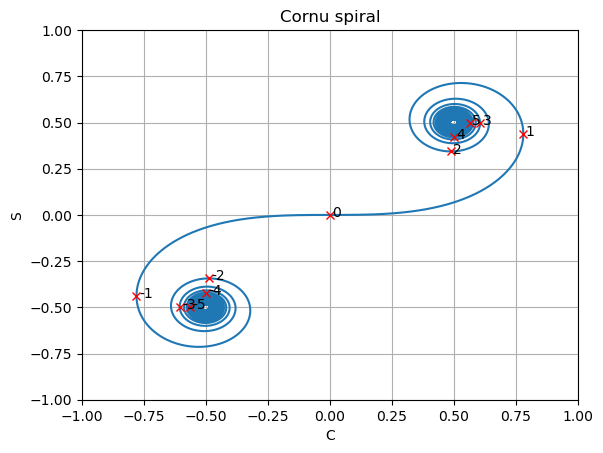

In [7]:
def cornu_C_integrand(x: float) -> float:
    return np.cos(np.pi * (x ** 2) / 2)

def cornu_S_integrand(x: float) -> float:
    return np.sin(np.pi * (x ** 2) / 2)

def cornu_C(u: float) -> float:
    return scipy.integrate.quad(cornu_C_integrand, 0, u)[0]

def cornu_S(u: float) -> float:
    return scipy.integrate.quad(cornu_S_integrand, 0, u)[0]

def plot_cornu():
    samples = 10000
    lim = 20
    u = np.linspace(-lim, lim, samples)
    C = [cornu_C(uu) for uu in u]
    S = [cornu_S(uu) for uu in u]
    plt.plot(C, S)

    integer_u = range(-5, 5 + 1)
    int_C = [cornu_C(uu) for uu in integer_u]
    int_S = [cornu_S(uu) for uu in integer_u]
    plt.plot(int_C, int_S, marker = "x", markersize = 6, linestyle = "", color = "r")
    for uu, cc, ss in zip(integer_u, int_C, int_S):
        plt.annotate(str(uu), (cc + 0.01, ss - 0.01)) # so that text isn't on marker

    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.title('Cornu spiral')
    plt.xlabel('C')
    plt.ylabel('S')
    plt.show()

plot_cornu()


very pretty...


## Supplementary Task 2: Fresnel diffraction
Now the wavefunction is given by
\begin{equation}
  \psi \propto \left[C(u)\right]^{x_1}_{x_0} + \left[iS(u)\right]^{x_1}_{x_0}
\end{equation}

Where the $u$ is related to $x$ by
\begin{equation}
  u = x \sqrt{\frac{2}{\lambda D}}
\end{equation}

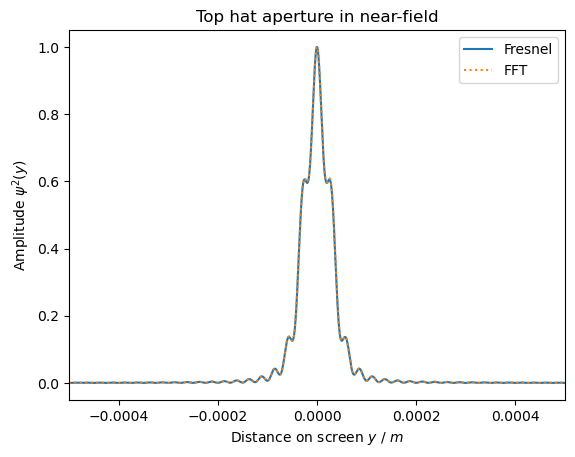

In [8]:
def get_fresnel_wfc(x: list, wavel: float, D: float) -> SupportsComplex:
    u = [xx * np.sqrt(2 / (wavel * D)) for xx in x]
    wfc = (cornu_C(u[1]) - cornu_C(u[0])) + 1j * (cornu_S(u[1]) - (cornu_S(u[0])))
    return wfc

def near_field_slit(wavel: float,
                    d: float,
                    D: float,
                    L: float,
                    fftsize: int):
    delta = L / fftsize
    
    def top_hat_corrected(x: float, d: float):
        return top_hat(x, d) * phase_factor(x, wavel, D)

    A = get_A_list(top_hat_corrected, fftsize, delta, d = d)
    wfc, y = fft(A, delta, wavel, D)
    intensity_fft = abs(wfc) ** 2
    # normalise max value to one for best comparison results...
    intensity_fft = intensity_fft / max(intensity_fft)

    # use the same y coordinate on fresnel
    fresnel_wfc = list()
    ll, rr = -d / 2, d / 2
    for i in range(len(y)):
        yy = y[i]
        fresnel_wfc.append(get_fresnel_wfc((ll - yy, rr - yy), wavel, D))
   
    fresnel_wfc = np.array(fresnel_wfc)
    intensity_fresnel = abs(fresnel_wfc) ** 2
    intensity_fresnel = intensity_fresnel / max(intensity_fresnel)

    plt.plot(y, intensity_fresnel, label = 'Fresnel')
    plt.plot(y, intensity_fft, label = 'FFT', linestyle = 'dotted')
    plt.xlabel('Distance on screen $y$ / $m$')
    plt.ylabel('Amplitude $\psi^2(y)$')
    plt.legend()
    plt.xlim(-0.5e-3, 0.5e-3)

    plt.title('Top hat aperture in near-field')
    plt.show()

near_field_slit(wavel = wavel, d = 100e-6, D = 5e-3, L = L, fftsize = 2 ** 11)


We can indeed say the fit is really quite good...